In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer

from Adam import Adam
torch.manual_seed(0)
np.random.seed(0)

In [2]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


In [3]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (u0(x, 0), v0(x, 0), x, t)
        input shape: (batchsize, x=s, t=0, c=4)
        output: the solution 
        output shape: (batchsize, x=s, t=3, c=2)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 18  # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width)  # input channel is 3: (u0(x, 1), u1(x, 1), x, t)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [self.padding, self.padding, self.padding, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-2*self.padding, :-2*self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x

    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [4]:


ntrain = 1000
ntest = 200

modes = 12
width = 32

batch_size = 20


epochs = 500
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)





t1 = default_timer()


sub = 1
S = 256 // sub
T_in = 1




data = scipy.io.loadmat('../Data/NLSG.mat')
t = data['t']
data = data['u']

T = t.shape[1] - T_in
train_a = data[:ntrain,::sub,:T_in]
train_a_m = torch.from_numpy(np.real(train_a))
train_a_n = torch.from_numpy(np.imag(train_a))
# train_a_m = train_a_m.reshape(ntrain,S,T_in,1)
# train_a_n = train_a_n.reshape(ntrain,S,T_in,1)
train_a = torch.cat((train_a_m,train_a_n), dim=-1)
train_a = train_a.type(torch.float32)

train_u = data[:ntrain,::sub,T_in:T+T_in]
train_u_m = torch.from_numpy(np.real(train_u))
train_u_n = torch.from_numpy(np.imag(train_u))
# train_u_m = train_u_m.reshape(ntrain,S,T,1)
# train_u_n = train_u_n.reshape(ntrain,S,T,1)
train_u = torch.cat((train_u_m,train_u_n), dim=-1)
train_u= train_u.type(torch.float32)

# reader = MatReader(TEST_PATH)
test_a = data[-ntest:,::sub,:T_in]
test_a_m = torch.from_numpy(np.real(test_a))
test_a_n = torch.from_numpy(np.imag(test_a))
# test_a_m = test_a_m.reshape(ntest,S,T_in,1)
# test_a_n = test_a_n.reshape(ntest,S,T_in,1)
test_a = torch.cat((test_a_m,test_a_n), dim=-1)
test_a = test_a.type(torch.float32)
#
test_u = data[-ntest:,::sub,T_in:T+T_in]
test_u_m = torch.from_numpy(np.real(test_u))
test_u_n = torch.from_numpy(np.imag(test_u))
# test_u_m = test_u_m.reshape(ntest,S,T,1)
# test_u_n = test_u_n.reshape(ntest,S,T,1)
test_u = torch.cat((test_u_m,test_u_n), dim=-1)
test_u = test_u.type(torch.float32)

print(train_a.shape,train_u.shape,test_a.shape,test_u.shape )



a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,1,T_in*2).repeat([1,1,T,1])
test_a = test_a.reshape(ntest,S,1,T_in*2).repeat([1,1,T,1])
print(train_a.shape,test_a.shape)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

################################################################
# training and evaluation
################################################################
model = FNO2d(modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


500 0.001 100 0.5
torch.Size([1000, 256, 2]) torch.Size([1000, 256, 198]) torch.Size([200, 256, 2]) torch.Size([200, 256, 198])
torch.Size([1000, 256, 99, 2]) torch.Size([200, 256, 99, 2])
preprocessing finished, time used: 2.6084987999999996
2368162


In [5]:
MSE = []
TrainL_2 = []
TestL_2 = []
best_test_l2 = float('inf')  # 记录最佳测试损失

t00 = default_timer()
myloss = LpLoss(size_average=False)
y_normalizer.cuda()

for ep in range(epochs):
    # ------------------------------
    # 训练阶段
    # ------------------------------
    model.train()
    t1 = default_timer()
    train_mse = 0.0
    train_l2 = 0.0
    
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()
        
        optimizer.zero_grad()
        out = model(x).view(batch_size, S, T*2)
        
        # 计算MSE损失（归一化空间）
        mse = F.mse_loss(out, y, reduction='mean')
        
        # 计算L2损失（物理空间）
        y_phys = y_normalizer.decode(y)
        out_phys = y_normalizer.decode(out)
        l2 = myloss(out_phys.view(batch_size, -1), y_phys.view(batch_size, -1))
        
        l2.backward()  # 使用L2损失反向传播
        optimizer.step()
        
        train_mse += mse.item() * x.size(0)  # 按样本数加权
        train_l2 += l2.item()
    
    scheduler.step()  # 更新学习率
    
    # ------------------------------
    # 验证阶段
    # ------------------------------
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()
            out = model(x).view(batch_size, S, T*2)
            out_phys = y_normalizer.decode(out)
            test_l2 += myloss(out_phys.view(batch_size, -1), y.view(batch_size, -1)).item()
    
    # 计算epoch平均损失
    train_mse /= len(train_loader.dataset)  # 修正为除以总样本数
    train_l2 /= ntrain
    test_l2 /= ntest
    
    # 保存损失记录
    MSE.append(train_mse)
    TrainL_2.append(train_l2)
    TestL_2.append(test_l2)
    
    # 保存最佳模型
    if test_l2 < best_test_l2:
        best_test_l2 = test_l2
        torch.save(model.state_dict(), 'model_fno.pth')
        print(f"Epoch {ep}: 保存最佳模型 (Test L2: {test_l2:.6f})")
    
    t2 = default_timer()
    print(f"Epoch {ep} | Time: {t2-t1:.2f}s | Train MSE: {train_mse:.6f} | Train L2: {train_l2:.6f} | Test L2: {test_l2:.6f}")

# 训练结束
t01 = default_timer()
print(f"训练完成 | 总时长: {t01-t00:.2f}s | 最佳Test L2: {best_test_l2:.6f}")

Epoch 0: 保存最佳模型 (Test L2: 0.229236)
Epoch 0 | Time: 9.70s | Train MSE: 0.752078 | Train L2: 0.449026 | Test L2: 0.229236
Epoch 1: 保存最佳模型 (Test L2: 0.149869)
Epoch 1 | Time: 6.67s | Train MSE: 0.236005 | Train L2: 0.184491 | Test L2: 0.149869
Epoch 2: 保存最佳模型 (Test L2: 0.105183)
Epoch 2 | Time: 7.28s | Train MSE: 0.139995 | Train L2: 0.127362 | Test L2: 0.105183
Epoch 3: 保存最佳模型 (Test L2: 0.085064)
Epoch 3 | Time: 7.41s | Train MSE: 0.094454 | Train L2: 0.096423 | Test L2: 0.085064
Epoch 4: 保存最佳模型 (Test L2: 0.074084)
Epoch 4 | Time: 14.75s | Train MSE: 0.076367 | Train L2: 0.080856 | Test L2: 0.074084
Epoch 5: 保存最佳模型 (Test L2: 0.062298)
Epoch 5 | Time: 16.63s | Train MSE: 0.063400 | Train L2: 0.068500 | Test L2: 0.062298
Epoch 6: 保存最佳模型 (Test L2: 0.054811)
Epoch 6 | Time: 19.58s | Train MSE: 0.053114 | Train L2: 0.058480 | Test L2: 0.054811
Epoch 7: 保存最佳模型 (Test L2: 0.051705)
Epoch 7 | Time: 25.26s | Train MSE: 0.046308 | Train L2: 0.055909 | Test L2: 0.051705
Epoch 8: 保存最佳模型 (Test L2: 0.

Epoch 82 | Time: 34.31s | Train MSE: 0.003738 | Train L2: 0.010328 | Test L2: 0.011008
Epoch 83 | Time: 34.66s | Train MSE: 0.003819 | Train L2: 0.011032 | Test L2: 0.011570
Epoch 84 | Time: 34.39s | Train MSE: 0.003771 | Train L2: 0.010795 | Test L2: 0.010564
Epoch 85 | Time: 34.47s | Train MSE: 0.003710 | Train L2: 0.009947 | Test L2: 0.013691
Epoch 86 | Time: 34.20s | Train MSE: 0.003938 | Train L2: 0.013053 | Test L2: 0.012288
Epoch 87 | Time: 34.22s | Train MSE: 0.003721 | Train L2: 0.009737 | Test L2: 0.007974
Epoch 88: 保存最佳模型 (Test L2: 0.007672)
Epoch 88 | Time: 34.46s | Train MSE: 0.003556 | Train L2: 0.008342 | Test L2: 0.007672
Epoch 89 | Time: 34.38s | Train MSE: 0.003540 | Train L2: 0.008895 | Test L2: 0.008061
Epoch 90 | Time: 34.52s | Train MSE: 0.003478 | Train L2: 0.008721 | Test L2: 0.009696
Epoch 91 | Time: 34.36s | Train MSE: 0.003509 | Train L2: 0.009514 | Test L2: 0.008076
Epoch 92 | Time: 34.45s | Train MSE: 0.003446 | Train L2: 0.008036 | Test L2: 0.009714
Epoch 

Epoch 172 | Time: 34.20s | Train MSE: 0.002278 | Train L2: 0.005595 | Test L2: 0.005586
Epoch 173 | Time: 34.35s | Train MSE: 0.002261 | Train L2: 0.005311 | Test L2: 0.006107
Epoch 174 | Time: 34.23s | Train MSE: 0.002241 | Train L2: 0.005028 | Test L2: 0.005517
Epoch 175 | Time: 34.27s | Train MSE: 0.002305 | Train L2: 0.006589 | Test L2: 0.005996
Epoch 176 | Time: 34.49s | Train MSE: 0.002251 | Train L2: 0.005424 | Test L2: 0.005163
Epoch 177 | Time: 34.53s | Train MSE: 0.002245 | Train L2: 0.005339 | Test L2: 0.005263
Epoch 178 | Time: 34.36s | Train MSE: 0.002257 | Train L2: 0.005489 | Test L2: 0.004704
Epoch 179 | Time: 34.47s | Train MSE: 0.002236 | Train L2: 0.005290 | Test L2: 0.004798
Epoch 180 | Time: 34.41s | Train MSE: 0.002251 | Train L2: 0.005146 | Test L2: 0.005737
Epoch 181 | Time: 34.48s | Train MSE: 0.002259 | Train L2: 0.005173 | Test L2: 0.006431
Epoch 182 | Time: 34.74s | Train MSE: 0.002238 | Train L2: 0.005751 | Test L2: 0.006406
Epoch 183 | Time: 34.47s | Train

Epoch 262 | Time: 34.84s | Train MSE: 0.001767 | Train L2: 0.003225 | Test L2: 0.003480
Epoch 263 | Time: 34.96s | Train MSE: 0.001780 | Train L2: 0.003579 | Test L2: 0.003375
Epoch 264 | Time: 34.78s | Train MSE: 0.001775 | Train L2: 0.003689 | Test L2: 0.004113
Epoch 265 | Time: 34.75s | Train MSE: 0.001769 | Train L2: 0.003530 | Test L2: 0.003375
Epoch 266 | Time: 34.50s | Train MSE: 0.001757 | Train L2: 0.003215 | Test L2: 0.003488
Epoch 267 | Time: 34.22s | Train MSE: 0.001765 | Train L2: 0.003602 | Test L2: 0.003213
Epoch 268 | Time: 34.35s | Train MSE: 0.001751 | Train L2: 0.003042 | Test L2: 0.003068
Epoch 269 | Time: 34.40s | Train MSE: 0.001744 | Train L2: 0.003047 | Test L2: 0.003042
Epoch 270 | Time: 34.89s | Train MSE: 0.001737 | Train L2: 0.003009 | Test L2: 0.002967
Epoch 271 | Time: 34.97s | Train MSE: 0.001741 | Train L2: 0.003448 | Test L2: 0.003722
Epoch 272 | Time: 34.77s | Train MSE: 0.001741 | Train L2: 0.003375 | Test L2: 0.003140
Epoch 273 | Time: 34.92s | Train

Epoch 353 | Time: 34.75s | Train MSE: 0.001531 | Train L2: 0.002653 | Test L2: 0.002727
Epoch 354 | Time: 34.54s | Train MSE: 0.001534 | Train L2: 0.002780 | Test L2: 0.002501
Epoch 355 | Time: 34.54s | Train MSE: 0.001533 | Train L2: 0.002826 | Test L2: 0.002763
Epoch 356 | Time: 34.54s | Train MSE: 0.001527 | Train L2: 0.002484 | Test L2: 0.002430
Epoch 357 | Time: 34.19s | Train MSE: 0.001526 | Train L2: 0.002597 | Test L2: 0.002818
Epoch 358: 保存最佳模型 (Test L2: 0.002355)
Epoch 358 | Time: 34.17s | Train MSE: 0.001522 | Train L2: 0.002439 | Test L2: 0.002355
Epoch 359 | Time: 34.34s | Train MSE: 0.001519 | Train L2: 0.002451 | Test L2: 0.002649
Epoch 360 | Time: 34.54s | Train MSE: 0.001520 | Train L2: 0.002613 | Test L2: 0.002577
Epoch 361: 保存最佳模型 (Test L2: 0.002297)
Epoch 361 | Time: 33.78s | Train MSE: 0.001516 | Train L2: 0.002404 | Test L2: 0.002297
Epoch 362 | Time: 34.05s | Train MSE: 0.001510 | Train L2: 0.002236 | Test L2: 0.002299
Epoch 363 | Time: 34.34s | Train MSE: 0.0015

Epoch 440: 保存最佳模型 (Test L2: 0.002043)
Epoch 440 | Time: 34.61s | Train MSE: 0.001395 | Train L2: 0.002021 | Test L2: 0.002043
Epoch 441: 保存最佳模型 (Test L2: 0.002037)
Epoch 441 | Time: 34.55s | Train MSE: 0.001394 | Train L2: 0.002024 | Test L2: 0.002037
Epoch 442: 保存最佳模型 (Test L2: 0.002034)
Epoch 442 | Time: 34.66s | Train MSE: 0.001392 | Train L2: 0.002014 | Test L2: 0.002034
Epoch 443 | Time: 34.71s | Train MSE: 0.001391 | Train L2: 0.002026 | Test L2: 0.002124
Epoch 444 | Time: 34.92s | Train MSE: 0.001391 | Train L2: 0.002160 | Test L2: 0.002113
Epoch 445 | Time: 35.17s | Train MSE: 0.001391 | Train L2: 0.002115 | Test L2: 0.002237
Epoch 446 | Time: 35.09s | Train MSE: 0.001389 | Train L2: 0.002094 | Test L2: 0.002063
Epoch 447 | Time: 34.86s | Train MSE: 0.001387 | Train L2: 0.002008 | Test L2: 0.002088
Epoch 448: 保存最佳模型 (Test L2: 0.002006)
Epoch 448 | Time: 34.97s | Train MSE: 0.001385 | Train L2: 0.001999 | Test L2: 0.002006
Epoch 449 | Time: 34.71s | Train MSE: 0.001384 | Train L

In [5]:
modes = 12
width = 32
model = FNO2d(modes, modes, width).cuda()
model.load_state_dict(torch.load('model_fno.pth'))
model.eval() 

FNO2d(
  (fc0): Linear(in_features=4, out_features=32, bias=True)
  (conv0): SpectralConv2d()
  (conv1): SpectralConv2d()
  (conv2): SpectralConv2d()
  (conv3): SpectralConv2d()
  (w0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (w3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [6]:
s_time = time.time()
Pred_L2 = []
pred = torch.zeros(test_u.shape)
index = 0
y_normalizer.cuda()
myloss = LpLoss(size_average=False)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()
        t1 = default_timer()
        out = model(x).view( S,  T*2)
        out = y_normalizer.decode(out)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        t2 = default_timer()
        print(f"第{index+1}个样本, 相对L2误差为{test_l2}")
        index = index + 1
        Pred_L2.append(test_l2)

    print(f"Total Time:{time.time() - s_time:.6f}s")      


第1个样本, 相对L2误差为0.0035323963966220617
第2个样本, 相对L2误差为0.0026404215022921562
第3个样本, 相对L2误差为0.0017269833479076624
第4个样本, 相对L2误差为0.001368318684399128
第5个样本, 相对L2误差为0.0012206574901938438
第6个样本, 相对L2误差为0.0014305043732747436
第7个样本, 相对L2误差为0.0025020150933414698
第8个样本, 相对L2误差为0.0018082846654579043
第9个样本, 相对L2误差为0.0016746479086577892
第10个样本, 相对L2误差为0.0016821810277178884
第11个样本, 相对L2误差为0.0016784811159595847
第12个样本, 相对L2误差为0.001649070531129837
第13个样本, 相对L2误差为0.002185819437727332
第14个样本, 相对L2误差为0.002612285315990448
第15个样本, 相对L2误差为0.00251003191806376
第16个样本, 相对L2误差为0.0014538714895024896
第17个样本, 相对L2误差为0.001528312568552792
第18个样本, 相对L2误差为0.0014605044852942228
第19个样本, 相对L2误差为0.002471331274136901
第20个样本, 相对L2误差为0.0022923832293599844
第21个样本, 相对L2误差为0.0025188690051436424
第22个样本, 相对L2误差为0.0015157765010371804
第23个样本, 相对L2误差为0.001090632169507444
第24个样本, 相对L2误差为0.0036369003355503082
第25个样本, 相对L2误差为0.0021870622877031565
第26个样本, 相对L2误差为0.00261638849042356
第27个样本, 相对L2误差为0.0018621963681653142
第28个样本, 相对L2误差为0.0015

In [ ]:
scipy.io.savemat('NLSG_FNO.mat', mdict={'pred': pred.cpu().numpy(),'MSE': MSE, 'TrainL_2': TrainL_2, 'TestL_2':TestL_2, 'Pred_L2':Pred_L2})

In [8]:
data = scipy.io.loadmat('../Data/NLSG.mat')
x = data["x"]
t = data["t"]
X, T = np.meshgrid(x,t[...,1:])
print(X.shape,T.shape)

u = data['u']
a = data['a']
u = u[-ntest:,:,1:]
print(a.shape)
print(u.shape)
pred = scipy.io.loadmat('NLSG_FNO.mat')
pred = pred['pred']
pred.shape

(99, 256) (99, 256)
(1500, 1)
(200, 256, 99)


(200, 256, 198)

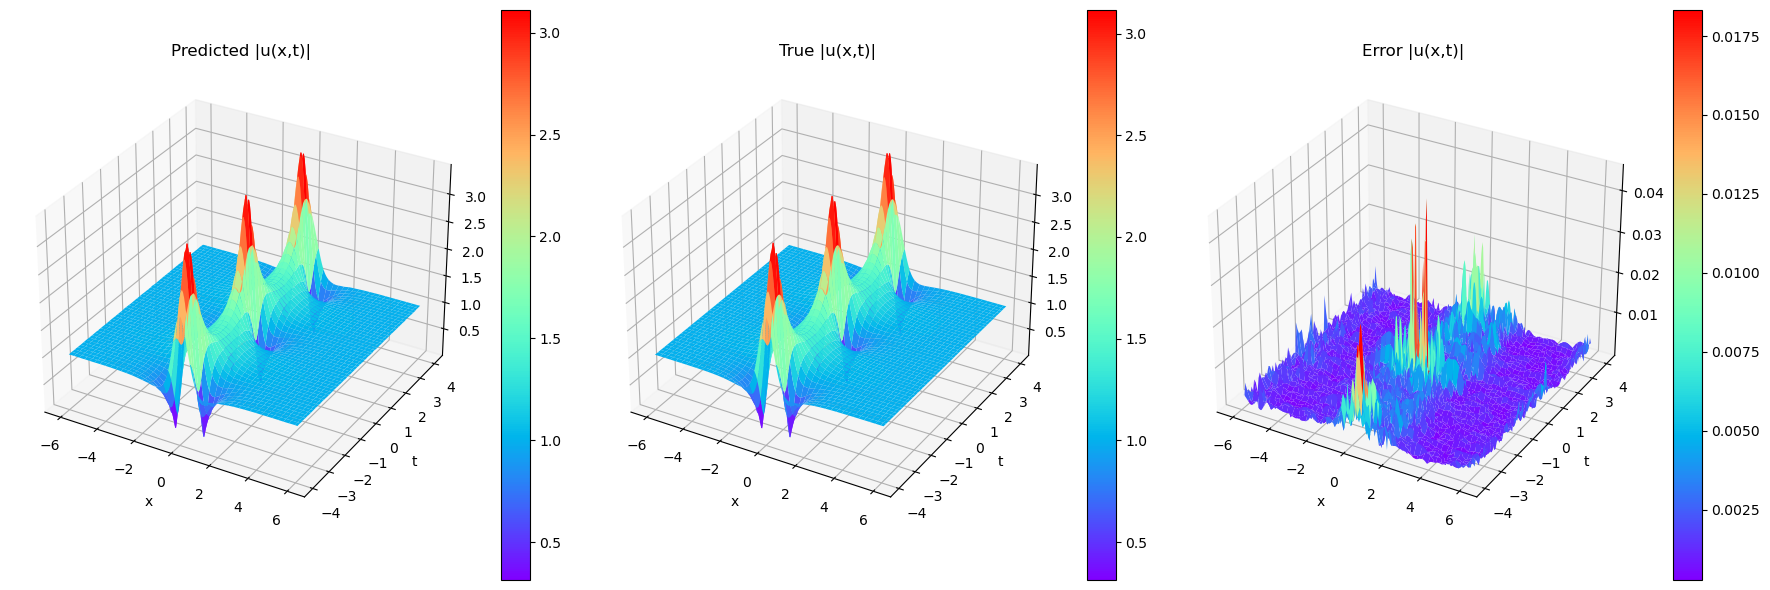

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经准备好这些数据
index_test = torch.randint(0, ntest, (1,))  # 获取随机的测试样本索引

# 获取预测值的实部和虚部
pred_real = pred[index_test, :, 0:t.shape[1] - 1]
pred_imag = pred[index_test, :, t.shape[1] - 1:]
pred_abs = np.sqrt(pred_real**2 + pred_imag**2)

# 获取真实解的实部和虚部
true_real = np.real(u[index_test, :, :])
true_imag = np.imag(u[index_test, :, :])
true_abs = np.sqrt(true_real**2 + true_imag**2)

# 计算误差：模的差异
error_abs = np.sqrt((pred_real - true_real)**2 + (pred_imag - true_imag)**2)

# 网格坐标
X, T = np.meshgrid(x.squeeze(), t.squeeze()[1:], indexing='ij')  # shape: (256, 99)

# 创建一个新的图形，包含三个子图
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# 绘制预测解的模
ax1 = axs[0]
surf1 = ax1.plot_surface(X, T, pred_abs, cmap='rainbow')
ax1.set_title("Predicted |u(x,t)|")
ax1.set_xlabel("x")
ax1.set_ylabel("t")
fig.colorbar(surf1, ax=ax1)

# 绘制真实解的模
ax2 = axs[1]
surf2 = ax2.plot_surface(X, T, true_abs, cmap='rainbow')
ax2.set_title("True |u(x,t)|")
ax2.set_xlabel("x")
ax2.set_ylabel("t")
fig.colorbar(surf2, ax=ax2)

# 绘制误差图像
ax3 = axs[2]
surf3 = ax3.plot_surface(X, T, error_abs, cmap='rainbow')
ax3.set_title("Error |u(x,t)|")
ax3.set_xlabel("x")
ax3.set_ylabel("t")
fig.colorbar(surf3, ax=ax3)

# 调整布局
plt.tight_layout()
plt.show()


